# Sales Forecast

Imagine you are working for a retail company. The company has asked you
to produce a 12-month forecast so that they can order items in time.
You have the daily number of sales for the past 5 years.

### Data Volume
How much data do you have to store if the company sells 10000 different products?

In [13]:
n_products = 1_000_000
product_description = 100000  # bytes = 100 kB per product, no images
n_days = 5 * 365
n_stores = 1
bytes_per_datapoint = 8 + 8   # sold items + timestamp
sales_data = bytes_per_datapoint * n_stores * n_days * n_products  # no individual purchases
sales_data += product_description * n_products
sales_data // 1000_000_000, "GB"
# 10+ TB --> GoogleBigQuery, Amazon Redshift, Snowflake

(129, 'GB')

### Data Size:  Rule of Thumb

* < 1 MB : do anything you want, it doesnt matter
* < 1 GB : pandas
* < 1 TB: single database (Postgres or other SQL)
* 1+ TB: consider distributed database system ( GoogleBigQuery, Amazon Redshift, Snowflake, Hadoop) or talk to a Data Engineer
* 1+ PetaByte: Hire a data engineering team

Buzzwords: Data Warehouse, Data Lake, Big Data

### Features
What might be important factors for the product categories "tulips", "jeans" and "screws"?

### Business Metrics 
How will you know that your model improves the business?

In [17]:
import seaborn as sns
df = sns.load_dataset('flights')
%matplotlib inline

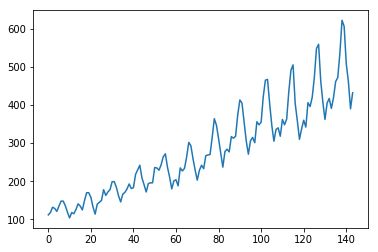

In [18]:
df['passengers'].plot()

### Feature Engineering

In [66]:
df['pct'] = df['passengers'].pct_change()

months = df.groupby('month')['pct'].mean()
months = list(months.values) * 12
df['pct'] = df['pct'] / months   # normalize by monthly averages

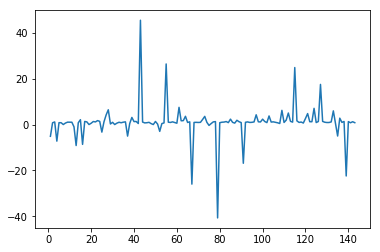

In [67]:
df['pct'].plot()

### Train-Test-Split

In [68]:
train = df[:120]
test = df[120:].copy()

In [69]:
train.shape, test.shape

((120, 4), (24, 4))

### Metrics

#### MAE  (mean absolute error)

Not very sensitive to outliers.

$\frac{1}{n} \sum |\hat y_i - y_T| $

#### RMSE (root mean square error)

Sometimes just MSE, sensitive to outliers.

$\sqrt{ \frac{1}{n} \sum (\hat y_i - y_T)^2 }$

Both MAE and RMSE have the same unit as y.

#### MAPE (mean absolute percentage error)

Useful to compare forecasts on different time series (products).

$\frac{1}{n} \sum \frac{|\hat y_i - y_T| * 100}{y_T}$

**!! This is not implemented anywhere, implement it yourself!!**

#### Also: RSMLE (root mean square logarithmic error)

penalizes underestimates more than overestimates

### Naive Forecasting Methods

In [70]:
# 1. always predict the mean
yhat = df['pct'].mean()
ypred = [yhat] * 24
test['mean'] = ypred

In [71]:
# 2. always predict the last value
yhat = df['pct'].iloc[-1]
test['last'] = [yhat] * 24

In [72]:
# 3. straight line through the first and last data point
first = df['pct'].iloc[1]  # first row is NaN
last = df['pct'].iloc[-1]
slope = (last - first) / 120

ypred = [last + slope * i for i in range(1, 25)]
test['trend'] = ypred

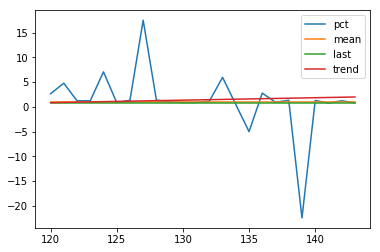

In [73]:
test[['pct', 'mean', 'last', 'trend']].plot()

In [74]:
import numpy as np

mae = np.abs(test['mean'] - test['pct']).mean()
print(mae, "mean MAE test")

mae = np.abs(test['last'] - test['pct']).mean()
print(mae, "last MAE test")

mae = np.abs(test['trend'] - test['pct']).mean()
print(mae, "trend MAE test")

2.82167646200471 mean MAE test
2.8963711842854405 last MAE test
3.0348962393364918 trend MAE test


In [86]:
# reconstruct the passenger number
y = test['pct'] * months[:24] + 1
y[120] = 1.0
test['true_reconstruct'] = y.cumprod() * test['passengers'][120] # opposite of the pct_change() function

In [87]:
y = test['mean'] * months[:24] + 1
y[120] = 1.0
test['mean_reconstruct'] = y.cumprod() * test['passengers'][120] # opposite of the pct_change() function

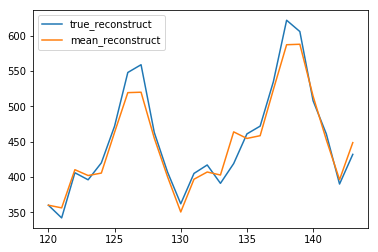

In [89]:
test[['true_reconstruct', 'mean_reconstruct']].plot()